In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment

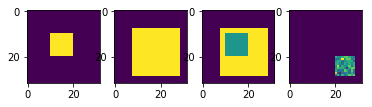

In [3]:
dna_seg = np.zeros((32,32,32))
dna_seg[10:20,10:20,10:20] = 1
mem_seg = np.zeros((32,32,32))
mem_seg[8:29,8:29,8:29] = 1
cyt_seg = mem_seg.copy()
cyt_seg[dna_seg==1] = 0
str_seg = np.random.randint(2, size=32*32*32).reshape(32,32,32)
str_seg[:20,:,:] = 0; str_seg[:,:20,:] = 0; str_seg[:,:,:20] = 0;
str_seg = str_seg*cyt_seg
fig, ax = plt.subplots(1,4)
ax[0].imshow(dna_seg.mean(axis=0))
ax[1].imshow(mem_seg.mean(axis=0))
ax[2].imshow(cyt_seg.mean(axis=0))
ax[3].imshow(str_seg.mean(axis=0))

In [10]:
def get_dispersion_features_single_run(image1_seg, image2_seg, normalize=True, number_of_samples=25, repetitions=400):

    coords = []
    coords.append(np.nonzero(image1_seg))
    coords.append(np.nonzero(image2_seg))
    
    for i in range(2):
        coords[i] = np.asarray(coords[i]).T
        #coords[i] = coords[i] + (np.random.rand(*coords[i].shape)-0.5)

    features = []
        
    if coords[0].shape[0] > number_of_samples and coords[1].shape[0] > number_of_samples:

        centroid = []
        diameter = []
        for i in range(2):
            centroid.append(coords[i].mean(axis=0))
            diameter.append(np.sqrt(((coords[i]-centroid[i])**2).sum(axis=1)).max())

        print(centroid[0],centroid[1])
        print(diameter[0],diameter[1])

        # Finding the reference set as the one with largest
        # diameter, usually the cytoplasm

        reference = 0 if diameter[0] > diameter[1] else 1

        # Shifting to the origin of reference set

        for i in range(2):
            coords[i] = coords[i] - centroid[reference]

        # Normalization by the diameter

        if normalize:
            for i in range(2):
                coords[i] /= diameter[reference]
                
        # Sampling points
                
        samples = []
        for i in [reference,1-reference,reference]:
            idx = np.random.choice(np.arange(coords[i].shape[0]), size=number_of_samples, replace=False)
            samples.append(coords[i][idx,:])

        fig, ax = plt.subplots(1,3,figsize=(15,5))
        for i in range(3):
            ax[i].plot(samples[i][:,1],samples[i][:,0],"o")
            ax[i].set_xlim(-1,1)
            ax[i].set_ylim(-1,1)
        plt.show()

        # Matrix of distance between sampled points

        dist_matrix_str = cdist(samples[0], samples[1])
        dist_matrix_ctl = cdist(samples[0], samples[2])

        # Solving the bipartite graph matching

        match_str_row, match_str_col = linear_sum_assignment(dist_matrix_str)
        match_ctl_row, match_ctl_col = linear_sum_assignment(dist_matrix_ctl)

        # View results

        fig, ax = plt.subplots(1,2,sharey=True,figsize=(10,4))
        ax[0].plot(samples[0][:,1],samples[0][:,0],"ro")
        ax[0].plot(samples[1][:,1],samples[1][:,0],"bo")
        ax[0].plot([samples[0][:,1],samples[1][match_str_col,1]],[samples[0][:,0],samples[1][match_str_col,0]],"r-")
        ax[0].set_xlim(-1,1)
        ax[0].set_ylim(-1,1)
        ax[1].plot(samples[0][:,1],samples[0][:,0],"ro")
        ax[1].plot(samples[2][:,1],samples[2][:,0],"bo")
        ax[1].plot([samples[0][:,1],samples[2][match_ctl_col,1]],[samples[0][:,0],samples[2][match_ctl_col,0]],"r-")
        ax[1].set_xlim(-1,1)
        ax[1].set_ylim(-1,1)
        plt.show()

        # Solving the closest neighbor matching

        match_str_local_col = np.argmin(dist_matrix_str,axis=1)
        match_str_local_row = np.argmin(dist_matrix_str,axis=0)
        match_ctl_local_col = np.argmin(dist_matrix_ctl,axis=1)
        match_ctl_local_row = np.argmin(dist_matrix_ctl,axis=0)

        # View results

        fig, ax = plt.subplots(1,2,sharey=True,figsize=(10,4))
        ax[0].plot(samples[0][:,1],samples[0][:,0],"ro")
        ax[0].plot(samples[1][:,1],samples[1][:,0],"bo")
        ax[0].plot([samples[0][:,1],samples[1][match_str_local_col,1]],[samples[0][:,0],samples[1][match_str_local_col,0]],"r-")
        ax[0].plot([samples[0][match_str_local_row,1],samples[1][:,1]],[samples[0][match_str_local_row,0],samples[1][:,0]],"b-")
        ax[0].set_xlim(-1,1)
        ax[0].set_ylim(-1,1)
        ax[1].plot(samples[0][:,1],samples[0][:,0],"ro")
        ax[1].plot(samples[2][:,1],samples[2][:,0],"bo")
        ax[1].plot([samples[0][:,1],samples[2][match_ctl_local_col,1]],[samples[0][:,0],samples[2][match_ctl_local_col,0]],"r-")
        ax[1].plot([samples[0][match_ctl_local_row,1],samples[2][:,1]],[samples[0][match_ctl_local_row,0],samples[2][:,0]],"b-")
        ax[1].set_xlim(-1,1)
        ax[1].set_ylim(-1,1)
        plt.show()

        # Calculating cost dispersion values

        cost_str_mean = dist_matrix_str[match_str_row, match_str_col].mean()
        cost_ctl_mean = dist_matrix_ctl[match_ctl_row, match_ctl_col].mean()
        cost_str_local_mean = np.mean([dist_matrix_str[np.arange(len(match_str_local_col)), match_str_local_col],dist_matrix_str[match_str_local_row, np.arange(len(match_str_local_col))]])
        cost_ctl_local_mean = np.mean([dist_matrix_ctl[np.arange(len(match_ctl_local_col)), match_ctl_local_col],dist_matrix_ctl[match_ctl_local_row, np.arange(len(match_ctl_local_col))]])

        cost_str_std = dist_matrix_str[match_str_row, match_str_col].std()
        cost_ctl_std = dist_matrix_ctl[match_ctl_row, match_ctl_col].std()
        cost_str_local_std = np.std([dist_matrix_str[np.arange(len(match_str_local_col)), match_str_local_col],dist_matrix_str[match_str_local_row, np.arange(len(match_str_local_col))]])
        cost_ctl_local_std = np.std([dist_matrix_ctl[np.arange(len(match_ctl_local_col)), match_ctl_local_col],dist_matrix_ctl[match_ctl_local_row, np.arange(len(match_ctl_local_col))]])

        print("Cost mean:",cost_str_mean, cost_ctl_mean)
        print("Cost mean:",cost_str_local_mean, cost_ctl_local_mean)

        print("Cost std:",cost_str_std, cost_ctl_std)
        print("Cost std:",cost_str_local_std, cost_ctl_local_std)

        features.append({"cost": cost_str_mean,
                         "cost_control": cost_ctl_mean,
                         "cost_local": cost_str_local_mean,
                         "cost_local_control": cost_ctl_local_mean,
                         "dispersion": cost_str_std,
                         "dispersion_control": cost_ctl_std,
                         "dispersion_local": cost_str_local_std,
                         "dispersion_local_control": cost_ctl_local_std})
        
    else:

        features.append({"cost": np.nan,
                         "cost_control": np.nan,
                         "cost_local": np.nan,
                         "cost_local_control": np.nan,
                         "dispersion": np.nan,
                         "dispersion_control": np.nan,
                         "dispersion_local": np.nan,
                         "dispersion_local_control": np.nan})
        
    return features

[24.00569801 23.88034188 24.04558405] [18.42367752 18.42367752 18.42367752]
6.968747160364581 18.05433906787992


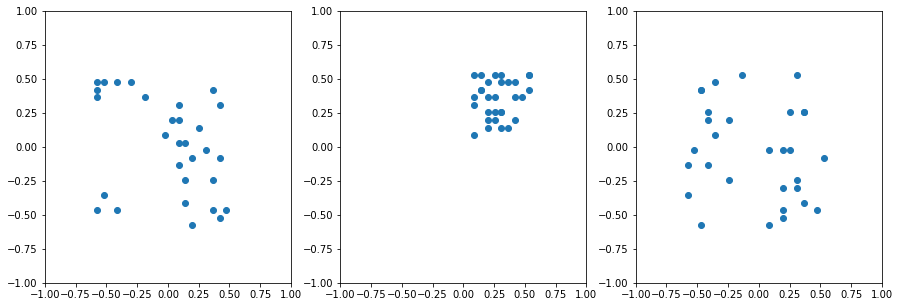

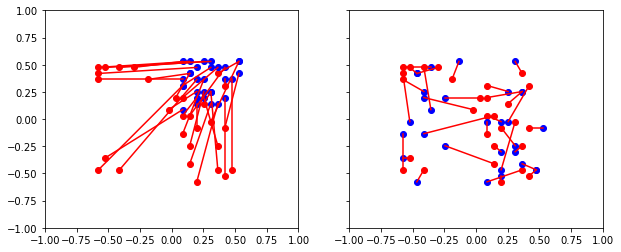

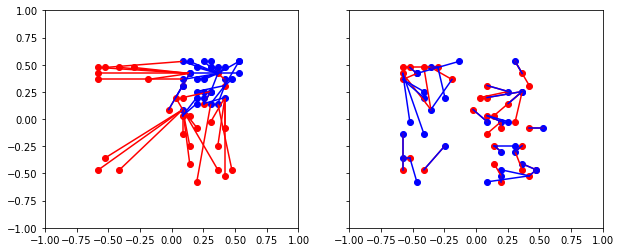

Cost mean: 0.6539394945532763 0.26515783862883374
Cost mean: 0.37622501208906217 0.21918498991599836
Cost std: 0.28784811830613055 0.1312549025340794
Cost std: 0.249628995487456 0.10021440321867074


In [11]:
df = get_dispersion_features_single_run(image1_seg=str_seg, image2_seg=cyt_seg, number_of_samples=30)

In [7]:
def get_dispersion_features(image1_seg, image2_seg, normalize=True, number_of_samples=50, repetitions=400):

    coords = []
    coords.append(np.nonzero(image1_seg))
    coords.append(np.nonzero(image2_seg))
    
    for i in range(2):
        coords[i] = np.asarray(coords[i]).T
        coords[i] = coords[i] + (np.random.rand(*coords[i].shape)-0.5)

    features = []
        
    if coords[0].shape[0] > number_of_samples and coords[1].shape[0] > number_of_samples:

        centroid = []
        diameter = []
        for i in range(2):
            centroid.append(coords[i].mean(axis=0))
            diameter.append(np.sqrt(((coords[i]-centroid[i])**2).sum(axis=1)).max())

        # Finding the reference set as the one with largest
        # diameter, usually the cytoplasm

        reference = 0 if diameter[0] > diameter[1] else 1

        # Shifting to the origin of reference set

        for i in range(2):
            coords[i] = coords[i] - centroid[reference]

        # Normalization by the diameter

        if normalize:
            for i in range(2):
                coords[i] /= diameter[reference]
                
        # Sampling points

        for realization in range(repetitions):
        
            samples = []
            for i in [reference,1-reference,reference]:
                idx = np.random.choice(np.arange(coords[i].shape[0]), size=number_of_samples, replace=False)
                samples.append(coords[i][idx,:])

            # Matrix of distance between sampled points

            dist_matrix_str = cdist(samples[0], samples[1])
            dist_matrix_ctl = cdist(samples[0], samples[2])

            # Solving the bipartite graph matching

            match_str_row, match_str_col = linear_sum_assignment(dist_matrix_str)
            match_ctl_row, match_ctl_col = linear_sum_assignment(dist_matrix_ctl)

            # Solving the closest neighbor matching

            match_str_local_col = np.argmin(dist_matrix_str,axis=1)
            match_str_local_row = np.argmin(dist_matrix_str,axis=0)
            match_ctl_local_col = np.argmin(dist_matrix_ctl,axis=1)
            match_ctl_local_row = np.argmin(dist_matrix_ctl,axis=0)

            # Calculating cost dispersion values

            cost_str_mean = dist_matrix_str[match_str_row, match_str_col].mean()
            cost_ctl_mean = dist_matrix_ctl[match_ctl_row, match_ctl_col].mean()
            cost_str_local_mean = np.mean([dist_matrix_str[np.arange(len(match_str_local_col)), match_str_local_col],dist_matrix_str[match_str_local_row, np.arange(len(match_str_local_col))]])
            cost_ctl_local_mean = np.mean([dist_matrix_ctl[np.arange(len(match_ctl_local_col)), match_ctl_local_col],dist_matrix_ctl[match_ctl_local_row, np.arange(len(match_ctl_local_col))]])

            cost_str_std = dist_matrix_str[match_str_row, match_str_col].std()
            cost_ctl_std = dist_matrix_ctl[match_ctl_row, match_ctl_col].std()
            cost_str_local_std = np.std([dist_matrix_str[np.arange(len(match_str_local_col)), match_str_local_col],dist_matrix_str[match_str_local_row, np.arange(len(match_str_local_col))]])
            cost_ctl_local_std = np.std([dist_matrix_ctl[np.arange(len(match_ctl_local_col)), match_ctl_local_col],dist_matrix_ctl[match_ctl_local_row, np.arange(len(match_ctl_local_col))]])

            features.append({"cost": cost_str_mean,
                             "cost_local": cost_str_local_mean,
                             "dispersion": cost_str_std,
                             "dispersion_local": cost_str_local_std,
                             "type": "data"})
            features.append({"cost": cost_ctl_mean,
                             "cost_local": cost_ctl_local_mean,
                             "dispersion": cost_ctl_std,
                             "dispersion_local": cost_ctl_local_std,
                             "type": "control"})

        features = pd.DataFrame(features)
        features = features.groupby("type").mean()
        features = features.reset_index()

    else:

        features.append({"cost": np.nan,
                         "cost_local": np.nan,
                         "dispersion": np.nan,
                         "dispersion_local": np.nan,
                         "type": "data"})
        features.append({"cost": np.nan,
                         "cost_local": np.nan,
                         "dispersion": np.nan,
                         "dispersion_local": np.nan,
                         "type": "control"})
        features = pd.DataFrame(features)

    return features

In [8]:
df = get_dispersion_features(image1_seg=str_seg, image2_seg=cyt_seg, number_of_samples=30, repetitions=2)

In [9]:
df.head()

,type,cost,cost_local,dispersion,dispersion_local
0,control,0.330261,0.257045,0.162844,0.115467
1,data,0.618226,0.395343,0.268023,0.229771


In [ ]:
df_total = pd.DataFrame([])
for ns in [10,20,30]:
    for rep in [10,50,100,200,300,400]:
        df = get_dispersion_features(image1_seg=str_seg, image2_seg=cyt_seg, number_of_samples=ns, repetitions=rep)
        df["number_of_samples"] = ns
        df["repetitions"] = rep
        df_total = df_total.append(df)

In [ ]:
df_total

In [ ]:
groups = df_total.groupby(["type","number_of_samples"])
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.repetitions, group.dispersion, marker='o', linestyle='--', ms=6, label=name)
ax.legend()
plt.show()